### Initialize notebook

In [10]:
import os
import sys
import traceback

sys.path.append('/home/ak/PycharmProjects/ature')
os.chdir('/home/ak/PycharmProjects/ature')

import torch
import torch.optim as optim
from neuralnet.unet.model.unet import UNet
from neuralnet.unet.unet_dataloader import split_drive_dataset, split_wide_dataset
from neuralnet.unet.unet_trainer import UNetNNTrainer
import torchvision.transforms as transforms

### Transformations

In [13]:
    sep = os.sep
    Params = {}
    Params['num_channels'] = 1
    Params['batch_size'] = 4
    Params['num_classes'] = 2
    Params['epochs'] = 150
    Params['patch_size'] = (388, 388)  # rows X cols
    Params['use_gpu'] = True
    Params['learning_rate'] = 0.001
    Params['distribute'] = True

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])
    # ---------------------------------------------------------------------------------------------------------
    # Define the network
    model = UNet(Params['num_channels'], Params['num_classes'])
    optimizer = optim.Adam(model.parameters(), lr=Params['learning_rate'])
    if Params['distribute']:
        model = torch.nn.DataParallel(model)
        optimizer = optim.Adam(model.module.parameters(), lr=Params['learning_rate'])

    """
    ################## UNET Drive Data set ################
    """
    try:
        Dirs = {}
        Dirs['train'] = 'data' + sep + 'DRIVE' + sep + 'training'
        Dirs['test'] = 'data' + sep + 'DRIVE' + sep + 'testing'
        Dirs['segmented'] = 'data' + sep + 'DRIVE' + sep + 'segmented_unet_thr'

        checkpoint = 'unet-DRIVE-THR.chk.tar'
        drive_trainer = UNetNNTrainer(model=model,
                                      checkpoint_file=checkpoint,
                                      log_file=checkpoint + '.csv',
                                      use_gpu=Params['use_gpu'])
        train_loader, val_loader, test_loader = split_drive_dataset(Dirs=Dirs, transform=transform,
                                                                    batch_size=Params['batch_size'])
        # drive_trainer.resume_from_checkpoint(parallel_trained=False)
#         drive_trainer.train(optimizer=optimizer,
#                             data_loader=train_loader,
#                             epochs=Params['epochs'],
#                             validation_loader=val_loader,
#                             force_checkpoint=False, log_frequency=20)
#         drive_trainer.resume_from_checkpoint(parallel_trained=False)
#         logger = drive_trainer.get_logger(checkpoint + '-TEST_THR.csv')
#         drive_trainer.evaluate(data_loader=test_loader, mode='eval', patch_size=(388, 388),
#                                segmented_out=Dirs['segmented'],
#                                logger=logger)
        logger.close()
    except Exception as e:
        traceback.print_exc()

### GPU not found.
Patches: 360
Patches: 6
Patches: 6
Patches: 6
Patches: 6
Patches: 6
Patches: 6
Patches: 6
Patches: 6
Patches: 6
Patches: 6
Patches: 6
Patches: 6
Patches: 6
Patches: 6
Patches: 6
Patches: 6
Patches: 6
Patches: 6
Patches: 6
Patches: 6


Traceback (most recent call last):
  File "<ipython-input-13-0742cac05d56>", line 51, in <module>
    logger.close()
NameError: name 'logger' is not defined


### Load train data

In [17]:
for i in train_loader:
    j = i[1][0, :,:,:]
    break

In [26]:
j = np.array(j*255, dtype=np.uint8).squeeze()

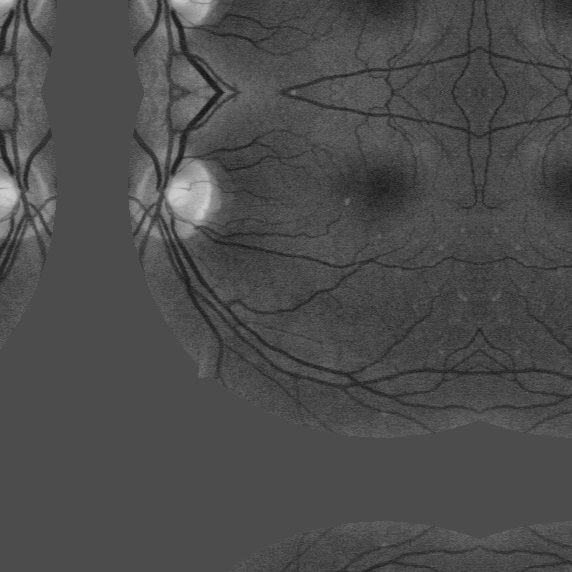

In [28]:
IMG.fromarray(j)

### Load Validation Data